# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud.
You can follow the steps below to guide your data analysis and model building portion of this project.

## 1.0 Import libraries and start the session.

In [55]:
#import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc,lit, min, max, split, udf,count\
,when,isnan,regexp_replace,countDistinct,month,from_unixtime,to_timestamp,lead,datediff,mean,to_date
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import *
from pyspark.sql.window import Window

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import re

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import MinMaxScaler, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


In [ ]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Churn Predictor") \
    .getOrCreate()

# 2.0 Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [ ]:
 #load spark data
df = spark.read.json('mini_sparkify_event_data.json')
df.persist()

### 2.1 Removing missing/incorrect values

In [ ]:
#remove user ids which are empty strings
df = df.filter(df["userId"] != "")

### 2.2 Timestamp formatting

In [ ]:
# change the original timestamp in the dataset to the common format
get_time = udf(lambda x: pd.Timestamp(x / 1000.0,unit='s').strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn("time", get_time(df.ts)).withColumn('registration_time',get_time(df.registration))
df = df.withColumn('month', month(col('time')))
df = df.withColumn('date', from_unixtime(col('ts')/1000).cast(DateType()))

#### The data is of rougly 2 months i.e from 1st October to 3rd December 2018. 

# 3.0 Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### 3.1 Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### 3.2 Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### 3.1.1 Churn means when a user cancels their association with the service. 
Using page =='Cancellation Confirmation' & auth =='Cancelled' I will label the users are churned (1) or not (0).

#### This shows that all user ids which are churned have page =='Cancellation Confirmation' & auth =='Cancelled' i.e there is no userId with only one factor.

In [ ]:
#label data
df = df.join(df.withColumn('churn',when(col('page')=='Cancellation Confirmation', 1).otherwise(0)).\
                            groupBy('userId').agg(Fsum('churn').alias('churn')), on='userId')

### 3.1.2 Analysing characteristics of churned users
#### 3.1.2.1 EDA on existing & new features (in Spark-EDA.ipynb)

# 4.0 Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary


### 4.1 
In this section, a few features engineered in EDA are used. These are -
1. Artist count
2. Songs count
3. No. of sessions
4. Total length
5. Visit count

A couple of features are tranformed in appropriate form -
6. Gender
7. Level

New features are also engineered. These are -
8. Page related
9. Avg. time of sessions
10. Gap between sessions
11. Item in session aggregate

In [ ]:
#This dataframe contains userId and churn columns only. Engineered features will be joined here.
user_churn = df.groupBy("userId").max("churn").withColumnRenamed("max(churn)", "churn").select(["userId", "churn"])

In [ ]:
#Count number of unique artists a user listens to
df_artist = df.groupby("userId") \
                                    .agg(countDistinct("artist")) \
                                    .withColumnRenamed("count(artist)", "artist_count")
user_churn = user_churn.join(df_artist,["userId"])

In [ ]:
#Calculate total number of times a userId is there in df
df_visits = df.groupby("userId") \
                                      .count() \
                                      .withColumnRenamed("count", "visit_count")
user_churn = user_churn.join(df_visits,["userId"])

In [ ]:
#Calculate numer of unique songs a user listens to 
df_count_songs = df.groupby("userId")\
                                    .agg(countDistinct("song"))\
                                    .withColumnRenamed("count(song)", "song_count")
user_churn = user_churn.join(df_count_songs,["userId"])

In [ ]:
#Calculate total length associated with each user
df_length = df.groupby("userId")\
                            .agg({"length" : "sum"})\
                               .withColumnRenamed("sum(length)","total_length")
user_churn = user_churn.join(df_length,["userId"])
#user_churn.show(n=5)

In [ ]:
#time related features

#1. Registered days i.e time between day of registration and now
user_time=df.groupBy('userId','registration_time').agg(min('time'),max('time'))
user_time=user_time.select('userId','registration_time',
                          to_timestamp('min(time)', 'yyyy-MM-dd HH:mm:ss').alias('first_time'),
                          to_timestamp('max(time)', 'yyyy-MM-dd HH:mm:ss').alias('last_time'))
#2.Days between last day for a user and last day in df
user_time=user_time.withColumn('registered_days',datediff('last_time','first_time')).withColumn(
    'last_recent',datediff(to_date(lit("2018-12-03")),'last_time')) #(2018-12-03) is the last date in the dataframe
user_time=user_time.select('userId','registered_days','last_recent')

user_churn=user_churn.join(user_time, ['userId'])
#user_churn.show()

In [ ]:
#turn gender into 0(M) and 1(F)
flag_gender = udf(lambda x: 1 if x == "F" else 0, IntegerType())
user_gender = df.withColumn("gender", flag_gender("gender"))
user_gender = user_gender.groupby('userId').agg({"gender": "max"}).withColumnRenamed("max(gender)", "gender")
user_churn=user_churn.join(user_gender, ['userId'])
#user_gender.show(5)

In [ ]:
#turn level into 0 and 1(paid)
flag_level = udf(lambda x: 1 if x == "paid" else 0, IntegerType())
user_level = df.withColumn("level", flag_level("level"))
user_level = user_level.groupby('userId').agg({"level": "max"}).withColumnRenamed("max(level)", "level")
user_churn=user_churn.join(user_level, ['userId'])
#user_level.show(5)

In [ ]:
#Calculate on avg. the number of items a user listens to everyday
daily_item_df = df.groupby('userId','date').agg(max('itemInSession')).\
                    groupBy('userId').avg('max(itemInSession)').\
                    withColumnRenamed('avg(max(itemInSession))', 'avg_daily_items')
user_churn = user_churn.join(daily_item_df,['userId'])
#user_churn.show()

In [ ]:
# page view related feature: calculate number of visited pages, proportion of different types of pages
df_page_view=df.groupBy('userId').pivot('page').count()
df_page_view=df_page_view.na.fill(0).drop('Cancellation Confirmation','Cancel')

df_page_totalview=df.filter("page != 'Cancellation Confirmation' and page != 'Cancel'" ).groupBy('userId').count()

# change actual number to percentage 
df_page_view=df_page_view.join(df_page_totalview,['userId'])
columns=df_page_view.columns
columns=[column for column in columns if column not in ('userId', 'count')]

for colName in columns:
    df_page_view = df_page_view.withColumn(colName, col(colName)/col('count'))

user_churn = user_churn.join(df_page_view,["userId"])
    

In [ ]:
# session related features

# calculate number of sessions of each user
user_session = df.groupby("userId").agg(countDistinct('sessionId'))


# calculate time of each session
user_session_time=df.groupBy('userId','sessionId').agg(min('time'),max('time')).orderBy('userId','sessionId')
user_session_time=user_session_time.select('userId','sessionId',
                          to_timestamp('min(time)', 'yyyy-MM-dd HH:mm:ss').alias('first_time'),
                          to_timestamp('max(time)', 'yyyy-MM-dd HH:mm:ss').alias('last_time'))

user_session_time=user_session_time.withColumn('session_duration_mins',(col("last_time").cast("long") - col("first_time")\
                                                                            .cast("long"))/60)

# calculate gap time of each pair of close sessions 

user_session_time=user_session_time.withColumn('next_session_start_time',lead(user_session_time['first_time'])
                                 .over(Window.partitionBy("userId").orderBy('sessionId')))    

user_session_time=user_session_time.withColumn('gap_time',datediff('next_session_start_time','first_time'))

# aggregate these two features at user level
user_session_time=user_session_time.groupBy('userId').agg(mean('session_duration_mins').alias('avg_session_duration_mins'),
                                           mean('gap_time').alias('avg_gap_time_days')).fillna(0)


#merge with user dataframe
df_session=user_session_time.join(user_session,["userId"])
user_churn = user_churn.join(df_session,["userId"])
#user_churn.show()

In [ ]:
#user_churn.write.save("final_data2.csv",format = "csv",header = True,)

In [ ]:
#user_churn.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in user_churn.columns]).collect()
#uncomment this to check if the user_churn dataframe has missing values

# 5.0 Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [ ]:
user_churn = user_churn.drop("userId") #we do not need userId for modelling
feature_columns = [col for col in user_churn.columns if col!='churn'] #feature columns don't include churn as that is the target

In [ ]:
#user_churn.printSchema()

#### Split data into Train & Test

In [ ]:
train, test = user_churn.randomSplit([0.7, 0.3], seed=42)
train = train.cache()

In [56]:
def build_model(classifier, param):
    """
    Builds a model based on the inputs
    Input:
    classifier - type of classifier
    param - built param grid
    Output :
    model - ML pipeline model
    """
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=param,
        evaluator = MulticlassClassificationEvaluator(labelCol='churn', metricName='f1'),
        numFolds=5,
    )
    return model

F1 score is used as an evaluation metric because in case of a skewed dataset, accuracy is unreliable. F1 score is a combination of precision and recall (2PR/(P+R)) and hence gives a better result. Area under curve(auc) can also be used.

### 5.1 Logistic Regression
Logistic Regression is the simplest classification algorithm. It is used as a baseline for evaluationg other models.

In [ ]:
#lr = LogisticRegression(featuresCol="scaled_features", labelCol="churn")
#lr_param = ParamGridBuilder().build()
#model = build_model(lr, lr_param)

In [ ]:
%%time
#fit_model = model.fit(train)

In [ ]:
#pred = fit_model.transform(test)

In [ ]:
#pred.select("prediction").dropDuplicates().collect()

In [58]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")
#f1_score = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
#print("f1: {}".format(f1_score))

### 5.2 Random Forest 

In [51]:
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="churn")
rf_param = ParamGridBuilder().build()
rf_model = build_model(rf, rf_param)

In [52]:
%%time
rf_fit_model = rf_model.fit(train)

CPU times: user 2.35 s, sys: 592 ms, total: 2.94 s
Wall time: 5min 32s


In [53]:
rf_pred = rf_fit_model.transform(test)

In [59]:
rf_f1_score = evaluator.evaluate(rf_pred, {evaluator.metricName: "f1"})
print("f1: {}".format(rf_f1_score))

f1: 0.8300747170148985


### 5.3 Gradient Boosting

In [ ]:
#gbt =GBTClassifier(featuresCol="scaled_features", labelCol="churn")
#gbt_param = ParamGridBuilder().build()
#gbt_model = build_model(gbt, gbt_param)

In [ ]:
%%time
#gbt_fit_model = gbt_model.fit(train)

In [ ]:
#gbt_pred = gbt_fit_model.transform(test)

In [ ]:
#gbt_pred.select("prediction").dropDuplicates().collect()

In [ ]:
#gbt_f1_score = evaluator.evaluate(gbt_pred, {evaluator.metricName: "f1"})
#print("f1: {}".format(gbt_f1_score))

With default parameters (without hyperparameter tuning), Random Forest(RF) gives me a better result than that of GBT classifier or Logistic Regression. It is also insensitive to imbalances. Hence, I will tune RF classifier. 

### 5.4 Hyperparameter tuning
#### Feature Importances


In [63]:
rf_feature_imp = pd.DataFrame({"feature":feature_columns,"importance" : rf_fit_model.bestModel.stages[2].featureImportances})
rf_feature_imp.sort_values(by = "importance",ascending = False).reset_index(drop=True)

,feature,importance
0,last_recent,0.241378
1,registered_days,0.121433
2,avg_gap_time_days,0.089996
3,Thumbs Down,0.076021
4,count(DISTINCT sessionId),0.055237
5,count(DISTINCT artist),0.049162
6,count(DISTINCT song),0.039429
7,Thumbs Up,0.037096
8,Downgrade,0.035938
9,visit_count,0.023893


In [45]:
classifier = RandomForestClassifier(featuresCol="scaled_features", labelCol="churn")

In [46]:
param_grid = ParamGridBuilder() \
    .addGrid(classifier.maxDepth,[10,20]) \
    .addGrid(classifier.numTrees, [20, 70]) \
    .build()

model_tuned = build_model(classifier, param_grid)

In [47]:
%%time
fit_model_tuned = model_tuned.fit(train)

CPU times: user 11.9 s, sys: 3.09 s, total: 15 s
Wall time: 33min 2s


In [48]:
best_model = fit_model_tuned.bestModel

In [49]:
best_model_pred = best_model.transform(test)

In [60]:
best_f1_score = evaluator.evaluate(best_model_pred, {evaluator.metricName: "f1"})
print("f1: {}".format(best_f1_score))

f1: 0.894032258064516


In [61]:
rf_tuned_feature_imp = pd.DataFrame({"feature":feature_columns,"importance" : best_model.stages[2].featureImportances})
rf_tuned_feature_imp.sort_values(by = "importance",ascending = False).reset_index(drop=True)

,feature,importance
0,last_recent,0.281452
1,registered_days,0.090355
2,avg_gap_time_days,0.080672
3,Thumbs Down,0.056604
4,count(DISTINCT artist),0.044727
5,Thumbs Up,0.040446
6,NextSong,0.038806
7,Downgrade,0.036481
8,count(DISTINCT sessionId),0.031141
9,visit_count,0.028938


In [62]:
print('Best parameters : max depth:{}, num Trees:{}'.\
          format(best_model.stages[2].getOrDefault('maxDepth'), best_model.stages[2].getNumTrees))

Best parameters : max depth:10, num Trees:70


In [64]:
pd_features = user_churn.drop("churn").toPandas()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


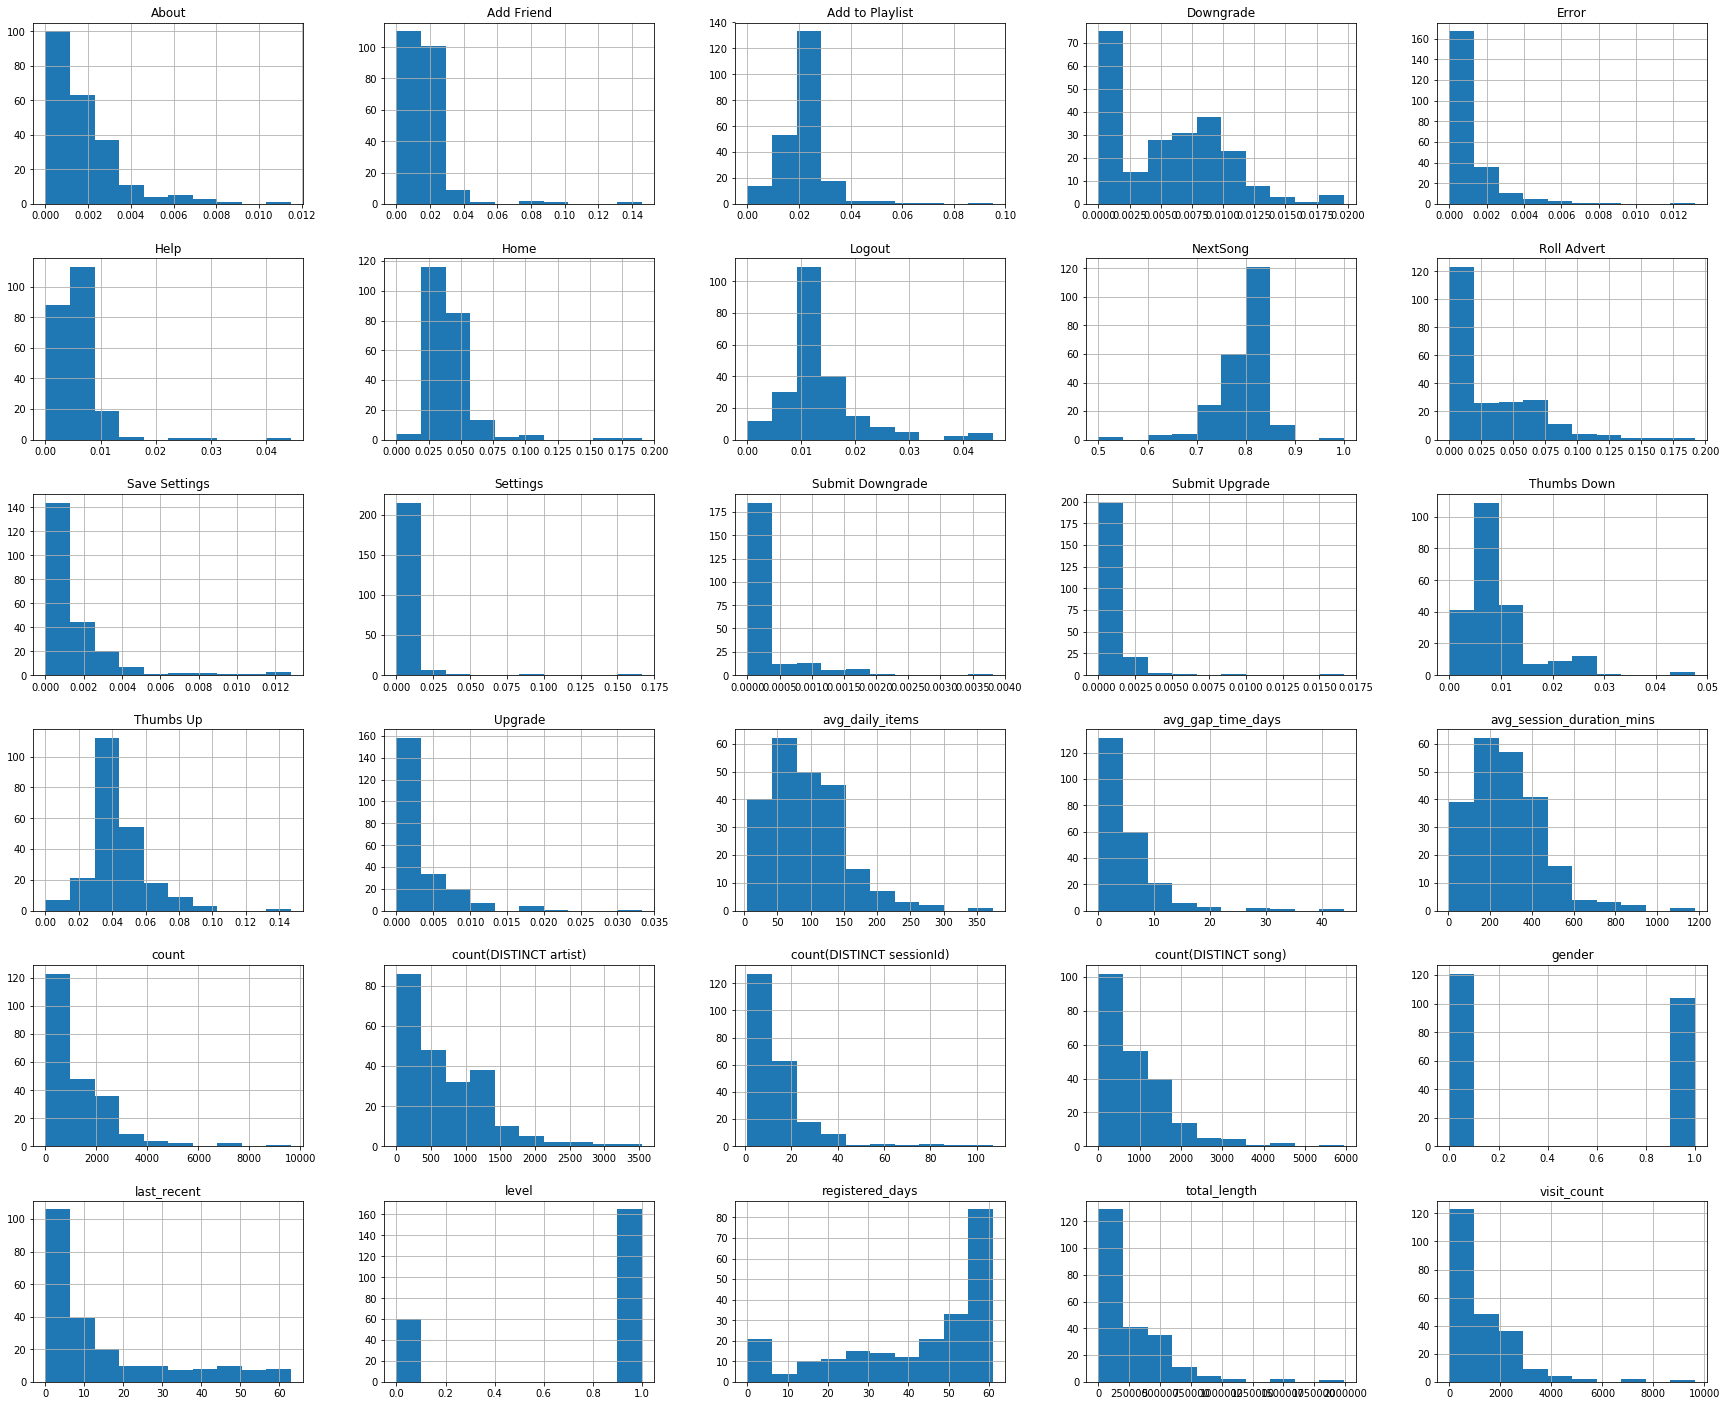

In [65]:
fig = plt.figure(figsize=(30,25))
ax = fig.gca()
h = pd_features.hist(ax=ax)

# 6.0 Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.